In [1]:
import pandas as pd
import numpy as np
import ast  # For safely converting string to list
import csv
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

In [2]:

# Open the file and process it manually
data = []
with open("../dataset/MOLHW_preprocess_unicode/big.txt", "r", encoding="utf-8") as file:
    reader = csv.reader(file)  # Read file line by line
    
    for row in reader:
        if not row:
            continue  # Skip empty lines
        
        first_5_columns = row[:5]  # First 5 columns
        last_column = ",".join(row[5:])  # Join remaining columns to reconstruct the coordinate array
        
        try:
            coordinates = ast.literal_eval(last_column)  # Convert string to list safely
        except Exception as e:
            print(f"Error parsing coordinates: {last_column} - {e}")
            coordinates = None  # Handle errors gracefully
        
        data.append(first_5_columns + [coordinates])
df = pd.DataFrame(data, columns=["label", "author",  "width",  "height", "density", "coordinates"])


In [ ]:
# # Define file paths
# input_file = '../../dataset_preprocessing/MOLHW_preprocess_unicode/big.txt'  # Your large input file
# output_file = '../../dataset_preprocessing/MOLHW_preprocess_unicode/small.txt'  # File to save the first 1000 rows

# # Open the input file in read mode and output file in write mode
# with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
#     # Read the first 1000 lines
#     for i, line in enumerate(infile):
#         if i < 1000:
#             outfile.write(line)  # Write the line to the output file
#         else:
#             break  # Stop after 1000 lines

In [ ]:
def plot_points(x):
    """
    Plots individual points from a list of coordinate points and connects neighboring points with lines,
    but avoids drawing lines across (-1, -1) separators.
    """

    coords = df.iloc[x]['coordinates'][1:]
    img_width, img_height = int(df.iloc[x]['width']), int(df.iloc[x]['height'])

    # Scale figure
    plt.figure(figsize=(img_width / 150, img_height / 150))  

    # Convert normalized coordinates to image dimensions, keeping (-1, -1) separators
    scaled_coords = [(x * img_width, y * img_height) if (x, y) != (-1, -1) else (-1, -1) for x, y in coords]

    # Separate segments
    segments = []
    current_segment = []

    for point in scaled_coords:
        if point == (-1, -1):  
            if current_segment:  
                segments.append(current_segment)
                current_segment = []
        else:
            current_segment.append(point)

    if current_segment:
        segments.append(current_segment)

    
    for i, segment in enumerate(segments):
        if len(segment) > 1:
            x_vals, y_vals = zip(*segment)
            plt.plot(x_vals, y_vals, color='black', linewidth=2, linestyle='-')  
        
           

    # Flip Y-axis to match image coordinates
    plt.xlim(0, img_width)
    plt.ylim(0, img_height)
    plt.gca().invert_yaxis()

    # Add grid with transparency
    plt.grid(True, linestyle="--", alpha=0.5)

    # Add title
    plt.title(df.iloc[x]['label'], fontsize=12, fontweight='bold')
    
    
    plt.show()

    



In [15]:
def preprocess_image(x):
    coords = df.iloc[x]['coordinates'][1:]
    img_width, img_height = int(df.iloc[x]['width']), int(df.iloc[x]['height'])

    # Scale figure
    plt.figure(figsize=(img_width / 150, img_height / 150))  

    # Convert normalized coordinates to image dimensions, keeping (-1, -1) separators
    scaled_coords = [(x * img_width, y * img_height) if (x, y) != (-1, -1) else (-1, -1) for x, y in coords]

    # Separate segments
    segments = []
    current_segment = []

    for point in scaled_coords:
        if point == (-1, -1):  
            if current_segment:  
                segments.append(current_segment)
                current_segment = []
        else:
            current_segment.append(point)

    if current_segment:
        segments.append(current_segment)

    # Plot lines and points with distinct colors
    colors = ['blue', 'green', 'orange', 'purple', 'brown']  # Color options for segments
    for i, segment in enumerate(segments):
        if len(segment) > 1:
            x_vals, y_vals = zip(*segment)
            plt.plot(x_vals, y_vals, color=colors[i % len(colors)], linewidth=2, linestyle='-')  
        
           

    # Flip Y-axis to match image coordinates
    plt.xlim(0, img_width)
    plt.ylim(0, img_height)
    plt.gca().invert_yaxis()

    plt.axis("off")

    # Add grid with transparency
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.savefig("output_image.png", dpi=150, bbox_inches="tight", pad_inches=0)
    plt.show()

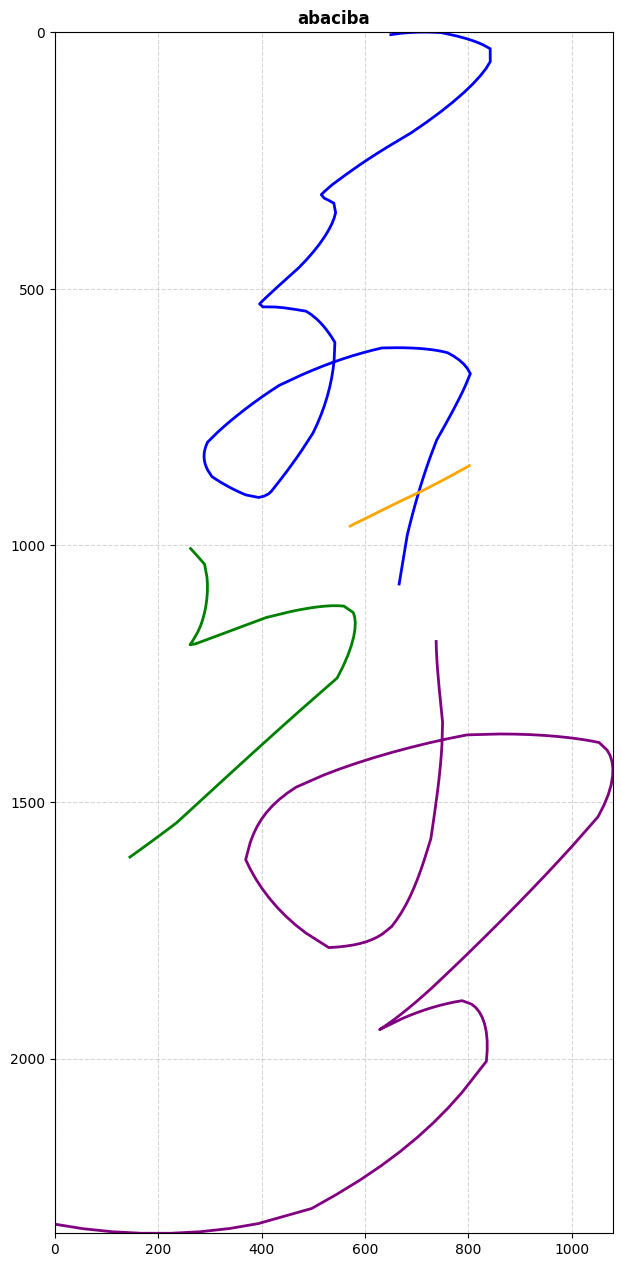

In [19]:
# Plot the points
plot_points(20)

In [16]:
def preprocess_imagea(x):
    coords = df.iloc[x]['coordinates'][1:]  
    img_width, img_height = int(df.iloc[x]['width']), int(df.iloc[x]['height'])

    # Scale figure
    plt.figure(figsize=(img_width / 150, img_height / 150))

    # Convert normalized coordinates to image dimensions
    scaled_coords = [(x * img_width, y * img_height) if (x, y) != (-1, -1) else (-1, -1) for x, y in coords]

    # Separate stroke segments
    segments = []
    current_segment = []

    for point in scaled_coords:
        if point == (-1, -1):
            if current_segment:
                segments.append(current_segment)
                current_segment = []
        else:
            current_segment.append(point)

    if current_segment:
        segments.append(current_segment)

    processed_segments = []

    for segment in segments:
        if len(segment) < 2:
            continue

        points = np.array(segment)

        # 1. **Interpolation using B-spline**
        tck, u = splprep(points.T, s=0)  
        u_new = np.linspace(0, 1, 100)  
        interpolated_points = np.array(splev(u_new, tck)).T  

        # 2. **Resampling (Uniform Spacing)**
        def resample_curve(points, num_samples=50):
            distances = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0) ** 2, axis=1)))
            distances = np.insert(distances, 0, 0)  
            uniform_distances = np.linspace(0, distances[-1], num_samples)  
            resampled_points = np.array([np.interp(uniform_distances, distances, points[:, i]) for i in range(2)]).T  
            return resampled_points

        resampled_points = resample_curve(interpolated_points)

        # 3. **Deletion (Threshold Check)**
        if len(resampled_points) < 50:
            continue  # Skip samples with too few points

        # 4. **Normalization (Centering & Y-Inversion)**
        def normalize_points(points, canvas_size=(img_width, img_height)):
            min_vals = points.min(axis=0)
            max_vals = points.max(axis=0)

            # Center the points
            centered_points = points - (min_vals + max_vals) / 2

            # Scale proportionally
            scale_factor = min(canvas_size[0] / (max_vals[0] - min_vals[0]), 
                                canvas_size[1] / (max_vals[1] - min_vals[1]))
            normalized_points = centered_points * scale_factor + np.array(canvas_size) / 2  

            # **Fix Y-axis inversion (Flip Y-coordinates manually)**
            normalized_points[:, 1] = canvas_size[1] - normalized_points[:, 1]

            return normalized_points

        normalized_points = normalize_points(resampled_points)
        processed_segments.append(normalized_points)

    # **Plot Processed Segments**
    colors = ['blue', 'green', 'orange', 'purple', 'brown']
    for i, segment in enumerate(processed_segments):
        if len(segment) > 1:
            x_vals, y_vals = zip(*segment)
            plt.plot(x_vals, y_vals, color=colors[i % len(colors)], linewidth=2, linestyle='-')

    # Set image properties
    plt.xlim(0, img_width)
    plt.ylim(0, img_height)
    # Ensure correct Y orientation
    plt.axis("off")

    # Add grid with transparency
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.savefig("output_image.png", dpi=150, bbox_inches="tight", pad_inches=0)

    plt.show()


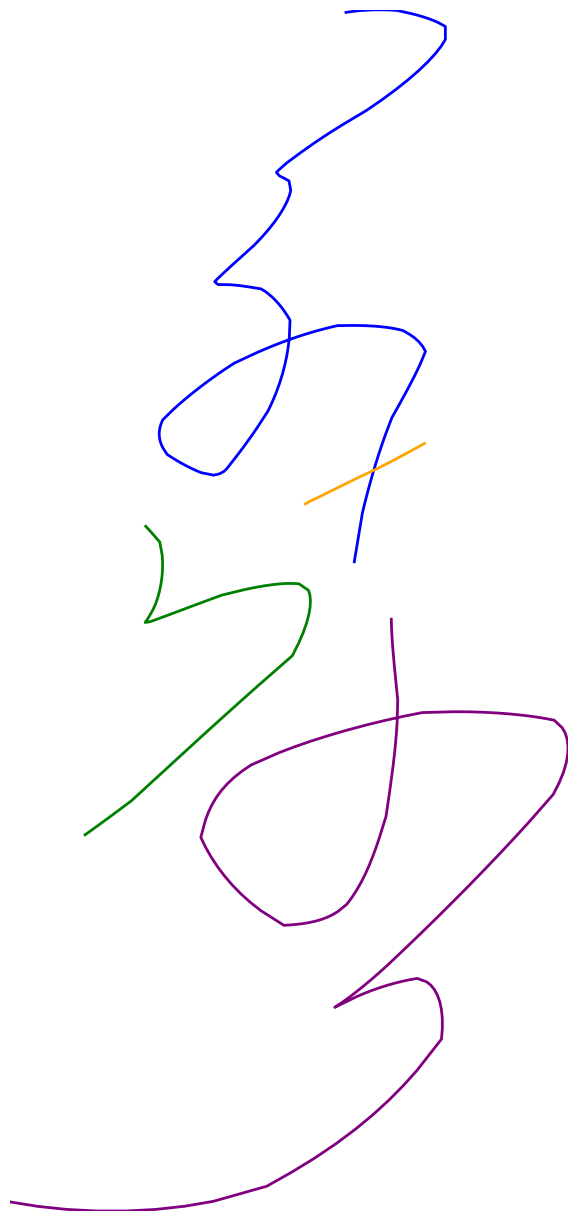

In [21]:
preprocess_image(20)

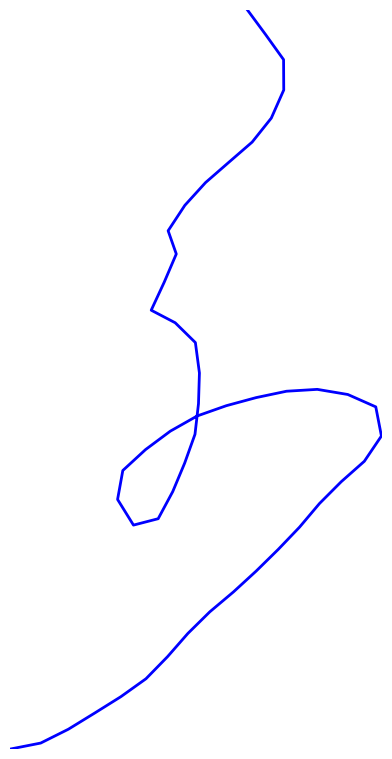

In [17]:
preprocess_imagea(3)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

def smooth_segment(segment, smoothing_factor=0.5):
    if len(segment) < 3:
        return segment  # No need to smooth if only two points
    
    x_vals, y_vals = zip(*segment)
    
    # Create parameter values (t) for the points
    t = np.linspace(0, 1, len(segment))
    
    # Create a B-spline representation
    tck, u = splprep([x_vals, y_vals], s=smoothing_factor)
    
    # Generate more interpolated points
    u_fine = np.linspace(0, 1, len(segment) * 5)  # Increase points for smoother curve
    smoothed = splev(u_fine, tck)
    
    return list(zip(smoothed[0], smoothed[1]))

def plot_points2(x, sm_fac = 0.5):
    """
    Plots individual points from a list of coordinate points and connects neighboring points with lines,
    but avoids drawing lines across (-1, -1) separators while smoothing the curves.
    """
    coords = df.iloc[x]['coordinates'][1:]
    img_width, img_height = int(df.iloc[x]['width']), int(df.iloc[x]['height'])
    
    # Scale figure
    plt.figure(figsize=(img_width / 150, img_height / 150))  
    
    # Convert normalized coordinates to image dimensions, keeping (-1, -1) separators
    scaled_coords = [(x * img_width, y * img_height) if (x, y) != (-1, -1) else (-1, -1) for x, y in coords]
    
    # Separate segments
    segments = []
    current_segment = []
    
    for point in scaled_coords:
        if point == (-1, -1):  
            if current_segment:  
                segments.append(current_segment)
                current_segment = []
        else:
            current_segment.append(point)
    
    if current_segment:
        segments.append(current_segment)
    
    for segment in segments:
        if len(segment) > 1:
            smoothed_segment = smooth_segment(segment, smoothing_factor=sm_fac)
            x_vals, y_vals = zip(*smoothed_segment)
            plt.plot(x_vals, y_vals, color='black', linewidth=2, linestyle='-')  
    
    # Flip Y-axis to match image coordinates
    plt.xlim(0, img_width)
    plt.ylim(0, img_height)
    plt.gca().invert_yaxis()
    
    # Add grid with transparency
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # Add title
    plt.title(df.iloc[x]['label'], fontsize=12, fontweight='bold')
    plt.savefig("output_image.png", dpi=150, bbox_inches="tight", pad_inches=0)
    plt.show()


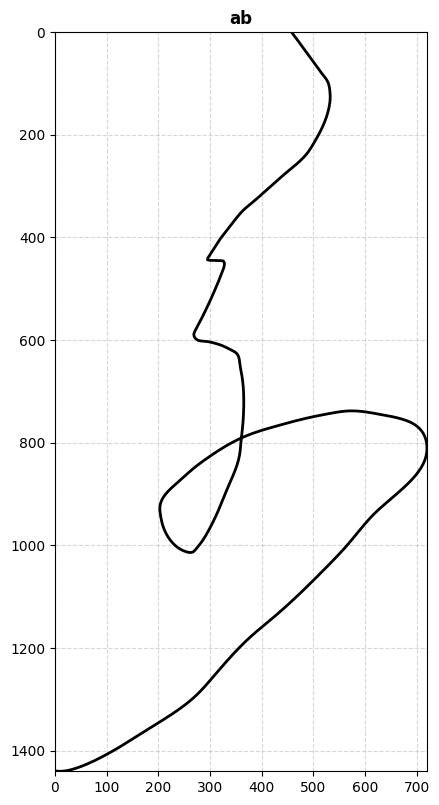

In [36]:
plot_points2(3, sm_fac=0.2)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
# Assuming 'df' is your pandas DataFrame loaded elsewhere

def plot_points_smooth(x, num_points_multiplier=10):
    """
    Plots points from a list of coordinates, connecting them with smooth cubic splines
    to mimic handwriting, while avoiding lines across (-1, -1) separators.

    Args:
        x (int): The index of the row in the DataFrame 'df' to plot.
        num_points_multiplier (int): Factor to increase the number of points for smoothness.
                                     Higher values mean smoother curves but more computation.
    """
    if 'df' not in globals():
        print("Error: DataFrame 'df' not found. Please ensure it's loaded.")
        return

    try:
        row_data = df.iloc[x]
        coords = row_data['coordinates'][1:]
        img_width, img_height = int(row_data['width']), int(row_data['height'])
        label = row_data['label']
    except (IndexError, KeyError) as e:
        print(f"Error accessing data at index {x}: {e}")
        return

    # Scale figure
    plt.figure(figsize=(img_width / 150, img_height / 150))

    # Convert normalized coordinates to image dimensions, keeping (-1, -1) separators
    scaled_coords = [(px * img_width, py * img_height) if (px, py) != (-1, -1) else (-1, -1) for px, py in coords]

    # Separate segments based on (-1, -1)
    segments = []
    current_segment = []
    for point in scaled_coords:
        if point == (-1, -1):
            if current_segment:
                segments.append(np.array(current_segment)) # Store as numpy array
                current_segment = []
        else:
            current_segment.append(point)
    if current_segment:
        segments.append(np.array(current_segment)) # Store as numpy array

    # Plot each segment
    for i, segment in enumerate(segments):
        num_points = len(segment)

        if num_points < 2:
            # If segment has 0 or 1 point, just plot the point(s) if desired, or skip
            if num_points == 1:
                 plt.plot(segment[0, 0], segment[0, 1], 'o', color='black', markersize=2) # Optional: plot single points
            continue # Cannot draw a line or spline

        x_vals = segment[:, 0]
        y_vals = segment[:, 1]

        # Use cubic spline interpolation for segments with enough points (>= 4)
        # Use linear interpolation (original method) for segments with 2 or 3 points
        if num_points >= 4:
            try:
                # Create a parameter t (index)
                t = np.arange(num_points)
                # Total number of points for the smooth curve
                num_smooth_points = num_points * num_points_multiplier
                # Generate smoother t values
                t_smooth = np.linspace(t.min(), t.max(), num_smooth_points)

                # Create interpolation functions for x and y separately
                # Use fill_value="extrapolate" just in case linspace goes slightly out of bounds
                interp_x = interp1d(t, x_vals, kind='cubic', fill_value="extrapolate")
                interp_y = interp1d(t, y_vals, kind='cubic', fill_value="extrapolate")

                # Calculate smooth x and y coordinates
                x_smooth = interp_x(t_smooth)
                y_smooth = interp_y(t_smooth)

                # Plot the smooth curve
                plt.plot(x_smooth, y_smooth, color='black', linewidth=2, linestyle='-')
            except ValueError as e:
                # Handle potential errors during interpolation (e.g., duplicate points might cause issues)
                print(f"Warning: Could not apply cubic spline to segment {i}. Falling back to linear. Error: {e}")
                plt.plot(x_vals, y_vals, color='black', linewidth=2, linestyle='-')

        elif num_points >= 2: # For 2 or 3 points, linear is the best we can do
            plt.plot(x_vals, y_vals, color='black', linewidth=2, linestyle='-')


    # Flip Y-axis to match image coordinates
    plt.xlim(0, img_width)
    plt.ylim(0, img_height)
    plt.gca().invert_yaxis()

    # Add grid with transparency
    plt.grid(True, linestyle="--", alpha=0.5)

    # Add title
    plt.title(label, fontsize=12, fontweight='bold')

    plt.show()

# --- Example Usage ---
# Make sure you have your DataFrame 'df' loaded before calling this function
# Example:
# import pandas as pd
# df = pd.read_json('your_data.json') # Or however you load your data

# plot_points_smooth(0) # Plot the first entry
# plot_points_smooth(10) # Plot the 11th entry

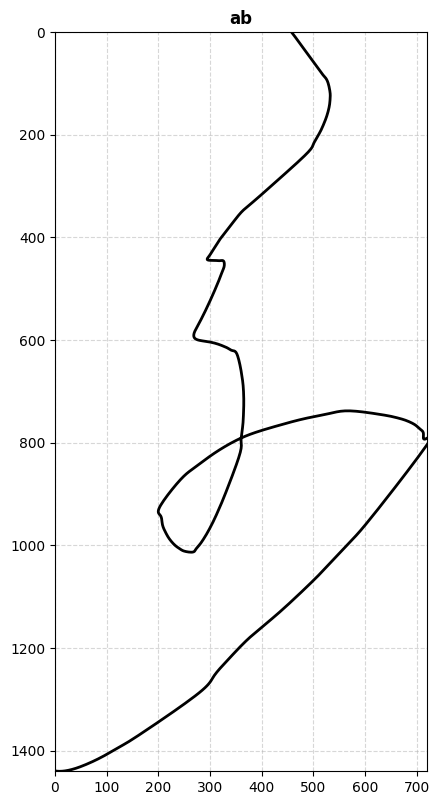

In [29]:
plot_points_smooth(3)

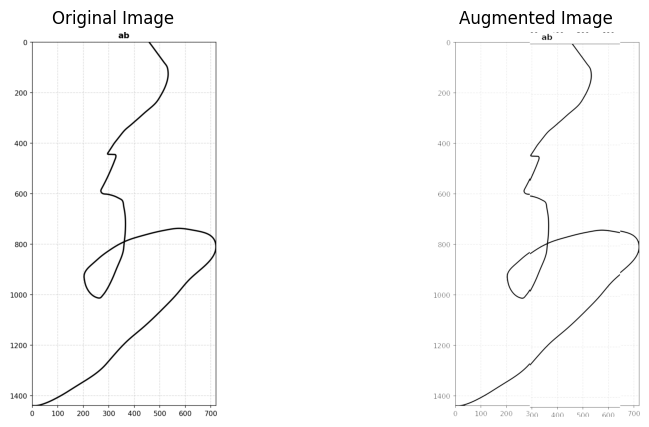

In [37]:
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont
import random
import matplotlib.pyplot as plt

def augment_stroke(image_path):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Simulate random stroke pulling (warp some parts of the text)
    rows, cols = image.shape
    # Randomly select a vertical section of the image
    pull_start = random.randint(0, cols // 2)
    pull_end = random.randint(cols // 2, cols)

    # Random vertical shift
    shift_value = random.randint(-5, 5)
    image[:, pull_start:pull_end] = np.roll(image[:, pull_start:pull_end], shift_value, axis=0)

    # Randomly vary stroke thickness
    kernel_size = random.choice([1, 2, 3, 4])
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)  # Apply dilation for stroke thickening

    # Simulate stroke thinning with erosion
    if random.random() < 0.5:
        kernel_size = random.choice([1, 2])
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        image = cv2.erode(image, kernel, iterations=1)  # Apply erosion for thinning

    return image

# Example usage
image_path = "output_image.png"
augmented_image = augment_stroke(image_path)

# Display the original vs augmented image
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Augmented Image")
plt.imshow(augmented_image, cmap="gray")
plt.axis('off')

plt.show()
